In [15]:
from pathlib import Path
import os 
from tqdm import tqdm
import wandb
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from data_utils import get_train_dataloader, get_test_dataloader
import torch.optim as optim
from torchvision import datasets, transforms
from models.our_alexnet import AlexNet
from models.inception import InceptionNet
from models.poggio_net import PoggioNet
from bound import *
import numpy as np

import matplotlib.pyplot as plt
model_path = "/om2/user/jackking/generalization-bounds/saved_models/"

In [16]:
# Initialize wandb API client
api = wandb.Api()
PROJECT_NAME = "generalization_bounds"
ENTITY_NAME = "generalization-bounds" 

# Fetch all runs in the project
try:
    runs = api.runs(f"{ENTITY_NAME}/{PROJECT_NAME}")
except Exception as e:
    print(f"Error fetching runs: {e}")
    exit()

# Find the run with the matching name
run_dict = {}
for run in runs:
    run_dict[run.name] = run

In [119]:
num_checkpoints = 11  # You can change this value
num_bounds = 4        # Set the number of bounds/rhos you know beforehand
threshold = 0.8
model_name = "AlexNet"
num_fc = 3 if model_name=='AlexNet' else 1

all_bounds = {i: [] for i in range(num_bounds)}
all_rhos = {i: [] for i in range(num_bounds)}
all_fc_ranks = {i: [] for i in range(num_fc)}
all_fc_frob = {i: [] for i in range(num_fc)}
all_fc_frob_2 = {i: [] for i in range(num_fc)}
all_conv_rhos = []

gaussian_levels = [0, 0.025, 0.05, 0.1, 0.25, 0.5, 0.75, 1.0]
random_label_levels = [0, 0.1, 0.25, 0.5, 0.75, 1.0]

# corruption_type_holder = "gaussian_images"
# levels = random_label_levels

corruption_type_holder = "partially_corrupted_labels"
levels = random_label_levels

all_train_accuracies = []
all_test_accuracies = []

for corruption_prob in levels:
    print("Corruption Prob: " + str(corruption_prob))
    if corruption_prob == 0:
        corruption_type = "None"
    else:
        corruption_type = corruption_type_holder

    train_loader = get_train_dataloader(dataset="CIFAR10", corruption_type=corruption_type,
                                        corruption_prob=corruption_prob)
    max_pix = max_pixel_sums(train_loader)

    if corruption_type != "None":
        save_dir = os.path.join(model_path, f"{model_name}/{corruption_type}/{corruption_prob}")
    else:
        save_dir = os.path.join(model_path, f"{model_name}/regular/")

    # Initialize arrays for this level
    bounds = [np.zeros((num_checkpoints, 0)) for _ in range(num_bounds)]
    rhos = [np.zeros((num_checkpoints, 0)) for _ in range(num_bounds)]
    train_accuracies = np.zeros((num_checkpoints, 0))
    test_accuracies = np.zeros((num_checkpoints, 0))

    cnn_rhos = []
    fc_ranks = {i: [] for i in range(num_fc)}
    fc_frobs = {i: [] for i in range(num_fc)}
    fc_frobs_2 = {i: [] for i in range(num_fc)}

    for run_index, run_name in tqdm(enumerate(os.listdir(save_dir))):
        model_dir = os.path.join(save_dir, run_name)
        print(run_name)

        num_checkpoints_in_dir = len([name for name in os.listdir(model_dir) if name.startswith("epoch_")])
        if num_checkpoints_in_dir != num_checkpoints:
            print(f"Skipping {run_name} due to incorrect number of checkpoints.")
            continue

        selected_run = run_dict[run_name]
        history = selected_run.history(keys=["train_accuracy", "val_accuracy"])
        train_accuracy_full = history["train_accuracy"]
        test_accuracy_full = history["val_accuracy"]

        checkpoints = [i*10 for i in range(num_checkpoints-1)]+[(num_checkpoints-2)*10+9]
        train_accuracy = np.array([train_accuracy_full[i] for i in checkpoints])
        test_accuracy = np.array([test_accuracy_full[i] for i in checkpoints])

        train_accuracies = np.hstack((train_accuracies, train_accuracy.reshape(-1, 1)))
        test_accuracies = np.hstack((test_accuracies, test_accuracy.reshape(-1, 1)))

        # Lists to store the per-run values before stacking
        run_bounds_lists = [[] for _ in range(num_bounds)]
        run_rhos_lists = [[] for _ in range(num_bounds)]

        for epoch_idx, epoch in enumerate(np.arange(0, num_checkpoints * 10, 10)):
            state_dict = torch.load(os.path.join(model_dir, f"epoch_{epoch}.pt"))
            calc_results = calc_bounds(state_dict, train_loader, max_pix, model_name=model_name, threshold=threshold)

            # Assume calc_bounds returns num_bounds bounds followed by num_bounds rhos:
            # (bound1, ..., boundN, rho1, ..., rhoN)
            current_bounds = calc_results[:num_bounds]
            current_rhos = calc_results[num_bounds:]

            for i in range(num_bounds):
                run_bounds_lists[i].append(current_bounds[i])
                run_rhos_lists[i].append(current_rhos[i])
        
        #get rankedness stats
        state_dict = torch.load(os.path.join(model_dir, f"epoch_100.pt"))
        temp = calc_bounds(state_dict, train_loader, max_pix, model_name=model_name, threshold=threshold)
        cnn_rho, fc_rank, fc_frob, fc_frob_2 = calc_rankedness_stats(state_dict, threshold, model_name)
        #assert temp[7]==cnn_rho*fc_rank[0]*fc_rank[1]*fc_rank[2],f"{temp[7]} but got {cnn_rho*fc_rank[0]*fc_rank[1]*fc_rank[2]}"
        cnn_rhos.append(cnn_rho)
        for idx in range(num_fc):
            fc_ranks[idx].append(fc_rank[idx])
            fc_frobs[idx].append(fc_frob[idx])
            fc_frobs_2[idx].append(fc_frob_2[idx])

        # Convert run-specific lists to arrays and horizontally stack
        for i in range(num_bounds):
            run_bounds_array = np.array(run_bounds_lists[i]).reshape(-1, 1)
            bounds[i] = np.hstack((bounds[i], run_bounds_array))

            run_rhos_array = np.array(run_rhos_lists[i]).reshape(-1, 1)
            rhos[i] = np.hstack((rhos[i], run_rhos_array))


    # After processing all runs for this corruption level, append results to global structures
    for i in range(num_bounds):
        all_bounds[i].append(bounds[i])
        all_rhos[i].append(rhos[i])

    all_train_accuracies.append(train_accuracies)
    all_test_accuracies.append(test_accuracies)

    for idx in range(num_fc):
        all_fc_ranks[idx].append(np.array(fc_ranks[idx]))
        all_fc_frob[idx].append(np.array(fc_frobs[idx]))
        all_fc_frob_2[idx].append(np.array(fc_frobs_2[idx]))
    all_conv_rhos.append(cnn_rhos)

    print()

for idx in range(num_fc):
    all_fc_ranks[idx]=(np.array(all_fc_ranks[idx]))
    all_fc_frob[idx]=(np.array(all_fc_frob[idx]))
    all_fc_frob_2[idx]=(np.array(all_fc_frob_2[idx]))
all_conv_rhos = np.array(all_conv_rhos)

Corruption Prob: 0
Files already downloaded and verified


0it [00:00, ?it/s]

daily-terrain-302


1it [00:01,  1.31s/it]

hearty-elevator-326


2it [00:02,  1.27s/it]

pious-dust-303


3it [00:03,  1.23s/it]

pretty-water-319


4it [00:05,  1.26s/it]

young-meadow-312


5it [00:06,  1.28s/it]



Corruption Prob: 0.1
Files already downloaded and verified


0it [00:00, ?it/s]

frosty-elevator-370


1it [00:01,  1.39s/it]

light-sun-311


2it [00:02,  1.34s/it]

magic-paper-334


3it [00:03,  1.30s/it]

noble-music-389


4it [00:05,  1.26s/it]

smooth-dust-353


5it [00:06,  1.29s/it]



Corruption Prob: 0.25
Files already downloaded and verified


0it [00:00, ?it/s]

classic-cloud-337


1it [00:01,  1.29s/it]

elated-plant-373


2it [00:02,  1.26s/it]

genial-frog-356


3it [00:03,  1.28s/it]

leafy-grass-390


4it [00:05,  1.32s/it]

northern-planet-315


5it [00:06,  1.31s/it]



Corruption Prob: 0.5
Files already downloaded and verified


0it [00:00, ?it/s]

astral-feather-321


1it [00:01,  1.36s/it]

comic-salad-342


2it [00:02,  1.32s/it]

polished-snowball-391


3it [00:04,  1.33s/it]

radiant-energy-377


4it [00:05,  1.32s/it]

swift-moon-359


5it [00:06,  1.33s/it]



Corruption Prob: 0.75
Files already downloaded and verified


0it [00:00, ?it/s]

helpful-wave-345


1it [00:01,  1.24s/it]

iconic-terrain-324


2it [00:02,  1.28s/it]

mild-meadow-363


3it [00:03,  1.32s/it]

northern-fire-393


4it [00:05,  1.34s/it]

stellar-tree-405
Skipping stellar-tree-405 due to incorrect number of checkpoints.
sweet-morning-381


6it [00:06,  1.10s/it]



Corruption Prob: 1.0
Files already downloaded and verified


0it [00:00, ?it/s]

apricot-water-366


1it [00:01,  1.38s/it]

earnest-haze-329


2it [00:02,  1.24s/it]

glowing-mountain-348


3it [00:03,  1.27s/it]

legendary-microwave-385


4it [00:05,  1.30s/it]

winter-bee-394


5it [00:06,  1.29s/it]

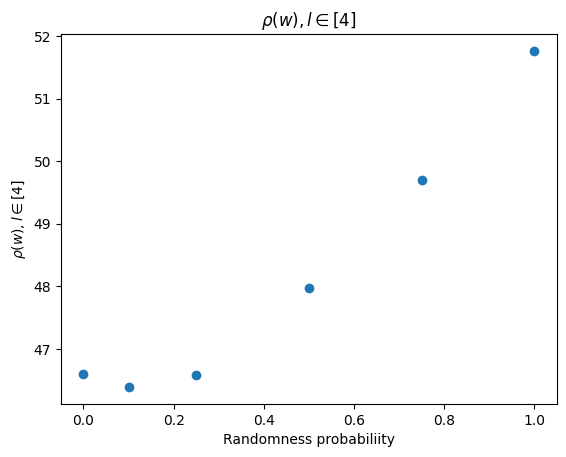

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


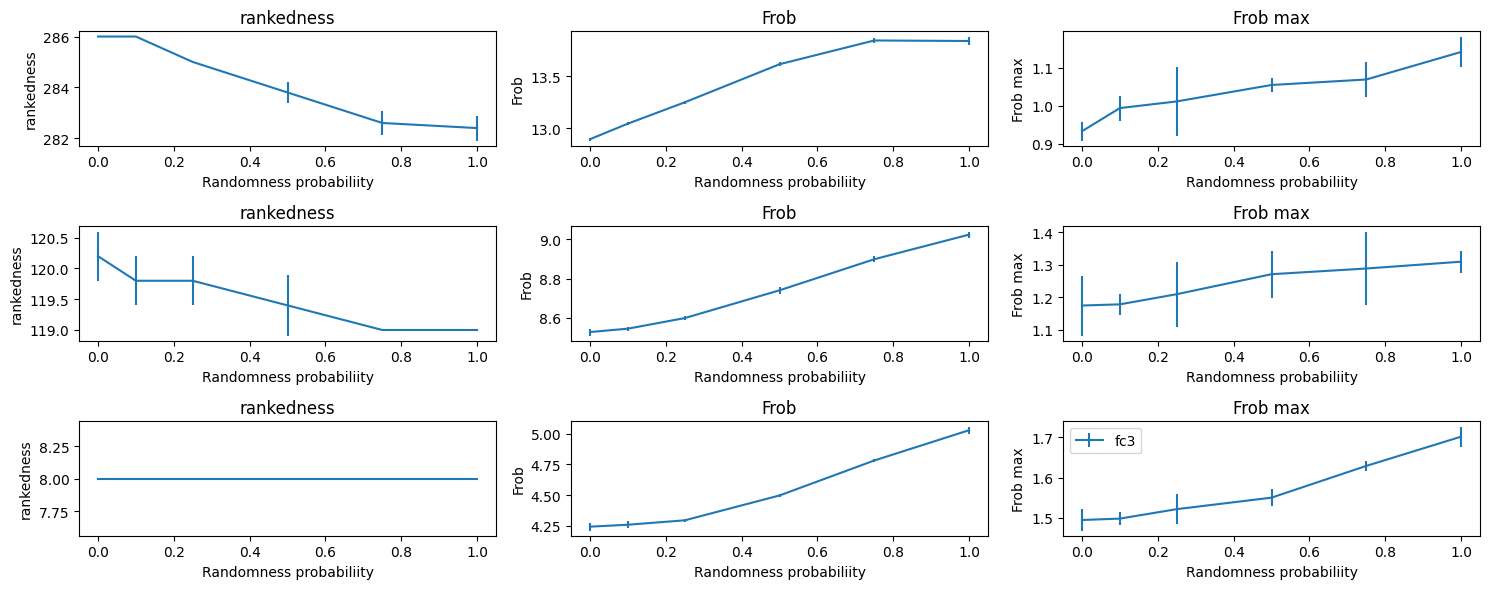

In [68]:
# plot rhos
datasets = [0,0.1,0.25,0.5,0.75,1.0]
plt.figure(0)
plt.scatter(datasets, [all_conv_rhos[i].mean() for i in range(len(datasets))])
plt.title(r"$\rho(w), l\in[4]$")
plt.xlabel("Randomness probabiliity")
plt.ylabel(r"$\rho(w), l\in[4]$")
plt.show()

fig,ax = plt.subplots(nrows=3, ncols=3, figsize=(15,6))
for i in range(num_fc):
    ax[i][1-1].errorbar(datasets, [all_fc_ranks[i][j].mean() for j in range(len(datasets))], label=f"fc{i+1}", yerr=[all_fc_ranks[i][j].std() for j in range(len(datasets))])
    ax[i][2-1].errorbar(datasets, [all_fc_frob[i][j].mean() for j in range(len(datasets))], label=f"fc{i+1}", yerr=[all_fc_frob[i][j].std() for j in range(len(datasets))])
    ax[i][3-1].errorbar(datasets, [all_fc_frob_2[i][j].mean() for j in range(len(datasets))], label=f"fc{i+1}", yerr=[all_fc_frob_2[i][j].std() for j in range(len(datasets))])
    ax[i][1-1].set_title("rankedness")
    ax[i][1-1].set_xlabel("Randomness probabiliity")
    ax[i][1-1].set_ylabel("rankedness")

    ax[i][2-1].set_title("Frob")
    ax[i][2-1].set_xlabel("Randomness probabiliity")
    ax[i][2-1].set_ylabel("Frob")

    ax[i][3-1].set_title("Frob max")
    ax[i][3-1].set_xlabel("Randomness probabiliity")
    ax[i][3-1].set_ylabel("Frob max")

    plt.tight_layout()
    plt.legend()

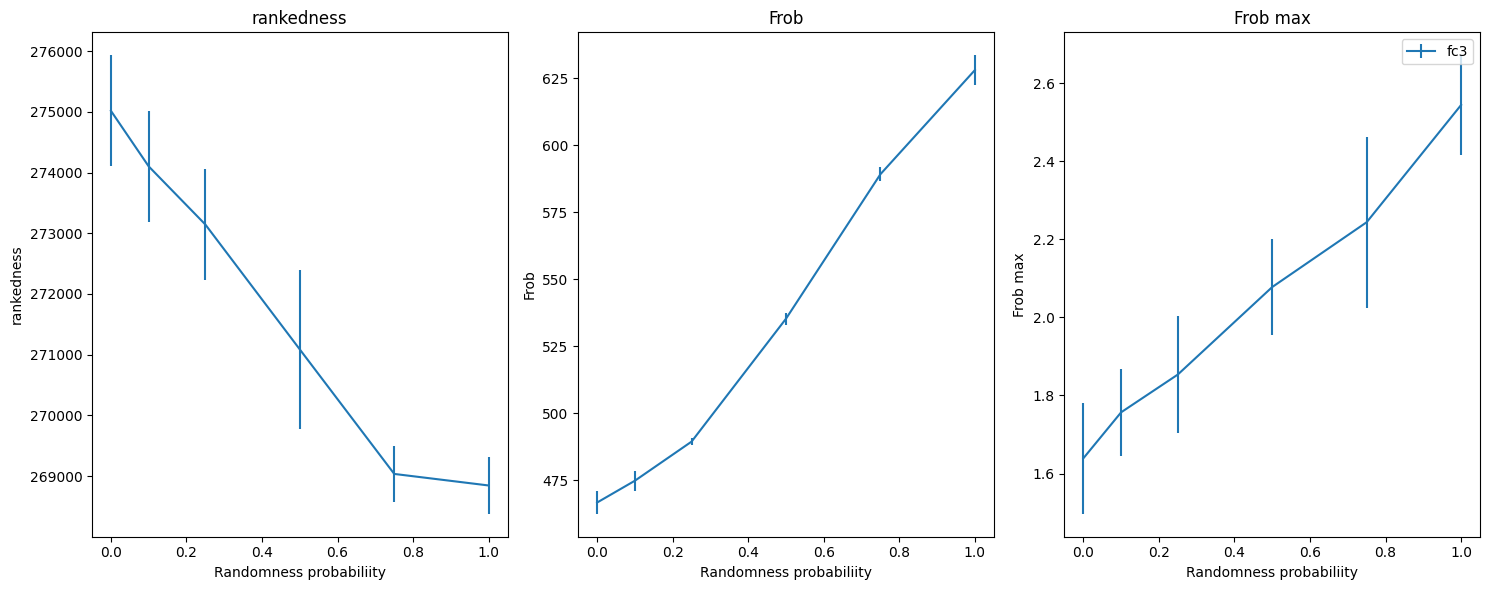

In [69]:
fig,ax = plt.subplots(nrows=1, ncols=3, figsize=(15,6))

ax[1-1].errorbar(datasets, [(all_fc_ranks[0][j]*all_fc_ranks[1][j]*all_fc_ranks[2][j]).mean() for j in range(len(datasets))], label=f"fc{i+1}", yerr=[(all_fc_ranks[0][j]*all_fc_ranks[1][j]*all_fc_ranks[2][j]).std() for j in range(len(datasets))])
ax[2-1].errorbar(datasets, [(all_fc_frob[0][j]*all_fc_frob[1][j]*all_fc_frob[2][j]).mean() for j in range(len(datasets))], label=f"fc{i+1}", yerr=[(all_fc_frob[0][j]*all_fc_frob[1][j]*all_fc_frob[2][j]).std() for j in range(len(datasets))])
ax[3-1].errorbar(datasets, [(all_fc_frob_2[0][j]*all_fc_frob_2[1][j]*all_fc_frob_2[2][j]).mean() for j in range(len(datasets))], label=f"fc{i+1}", yerr=[(all_fc_frob_2[0][j]*all_fc_frob_2[1][j]*all_fc_frob_2[2][j]).std() for j in range(len(datasets))])
ax[1-1].set_title("rankedness")
ax[1-1].set_xlabel("Randomness probabiliity")
ax[1-1].set_ylabel("rankedness")

ax[2-1].set_title("Frob")
ax[2-1].set_xlabel("Randomness probabiliity")
ax[2-1].set_ylabel("Frob")

ax[3-1].set_title("Frob max")
ax[3-1].set_xlabel("Randomness probabiliity")
ax[3-1].set_ylabel("Frob max")

plt.tight_layout()
plt.legend()

In [70]:
def plot():
    # Plotting
    for i in range(4):
        fig, axs = plt.subplots(1, 2, figsize=(20, 6))

        fig.suptitle("AlexNet-Small", fontsize=16)
        plt.tight_layout(w_pad=3.5)

        # Plot bounds
        for j, bound_array in enumerate(all_bounds[i]):
            # Calculate the mean and standard deviation across runs
            mean_across_runs = np.mean(bound_array, axis=1)
            std_across_runs = np.std(bound_array, axis=1)

            # Calculate the confidence interval (95% confidence)
            ci = 1.96 * (std_across_runs / np.sqrt(bound_array.shape[1]))

            # Plot the average across runs
            axs[0].plot(np.linspace(0, 100, num_checkpoints), mean_across_runs, label="r = " + str(levels[j]))
            axs[0].fill_between(np.linspace(0, 100, num_checkpoints), mean_across_runs - ci, mean_across_runs + ci, alpha=0.2)

        axs[0].legend()
        axs[0].set_title(f"Sparsity Generalization Bound {i+1} over Training")
        axs[0].set_xlabel("Epochs")
        axs[0].set_ylabel("SGB")

        idx = 1
        # Plot bounds
        for j, bound_array in enumerate(all_rhos[i]):
            # Calculate the mean and standard deviation across runs
            mean_across_runs = np.mean(bound_array, axis=1)
            std_across_runs = np.std(bound_array, axis=1)

            # Calculate the confidence interval (95% confidence)
            ci = 1.96 * (std_across_runs / np.sqrt(bound_array.shape[1]))

            # Plot the average across runs
            axs[idx].plot(np.linspace(0, 100, num_checkpoints), mean_across_runs, label="r = " + str(levels[j]))
            axs[idx].fill_between(np.linspace(0, 100, num_checkpoints), mean_across_runs - ci, mean_across_runs + ci, alpha=0.2)

        axs[idx].legend()
        axs[idx].set_title("Weight Norm over Training")
        axs[idx].set_xlabel("Epochs")
        axs[idx].set_ylabel(r"$\rho(w)$")

        plt.show()

        fig, axs = plt.subplots(1, 2, figsize=(20, 6))

        fig.suptitle("AlexNet-Small", fontsize=16, verticalalignment='center', y=0.98)
        plt.tight_layout(w_pad=1.5)

        idx = 1
        # Plot train_accuracy
        for j in range(len(all_train_accuracies)):
            train_accuracy = all_train_accuracies[j]
            mean_across_runs = np.mean(train_accuracy, axis=1)
            std_across_runs = np.std(train_accuracy, axis=1)
            ci = 1.96 * (std_across_runs / np.sqrt(train_accuracy.shape[1]))

            axs[idx].plot(np.linspace(0, 100, num_checkpoints), mean_across_runs, label="r = " + str(levels[j]))
            axs[idx].fill_between(np.linspace(0, 100, num_checkpoints), mean_across_runs - ci, mean_across_runs + ci, alpha=0.2)

        axs[idx].legend()
        axs[idx].set_title("Training Accuracy over Training")
        axs[idx].set_xlabel("Epochs")
        axs[idx].set_ylabel("Accuracy")

        idx = 0
        # Plot generalization error
        for j in range(len(all_train_accuracies)):
            generalization_error = all_train_accuracies[j] - all_test_accuracies[j]
            mean_across_runs = np.mean(generalization_error, axis=1)
            std_across_runs = np.std(generalization_error, axis=1)
            ci = 1.96 * (std_across_runs / np.sqrt(generalization_error.shape[1]))

            axs[idx].plot(np.linspace(0, 100, num_checkpoints), mean_across_runs, label="r = " + str(levels[j]))
            axs[idx].fill_between(np.linspace(0, 100, num_checkpoints), mean_across_runs - ci, mean_across_runs + ci, alpha=0.2)

        axs[idx].legend()
        axs[idx].set_title("Generalization Gap over Training")
        axs[idx].set_xlabel("Epochs")
        axs[idx].set_ylabel("Train Acc. - Test Acc.")

        plt.show()

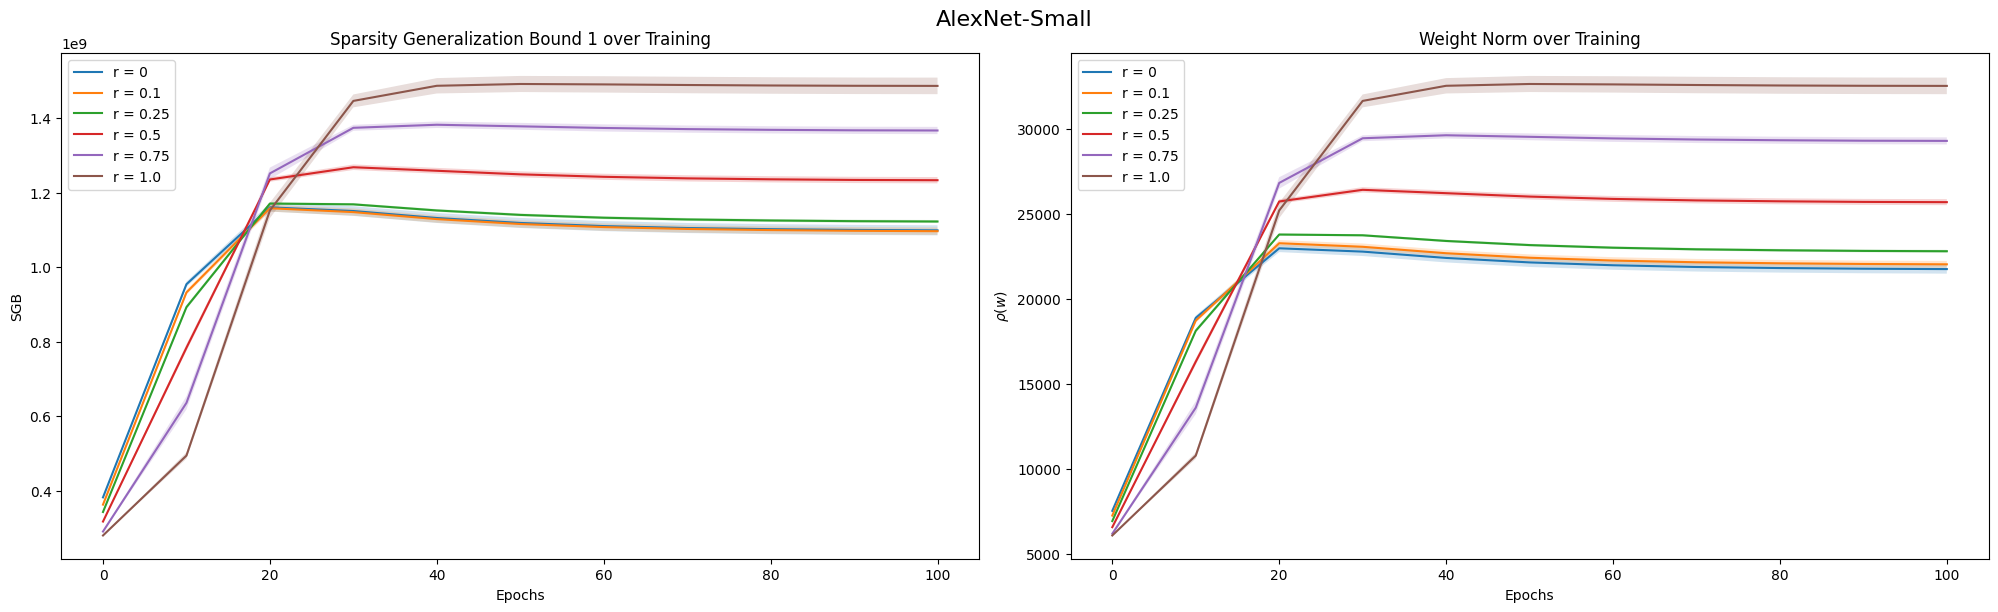

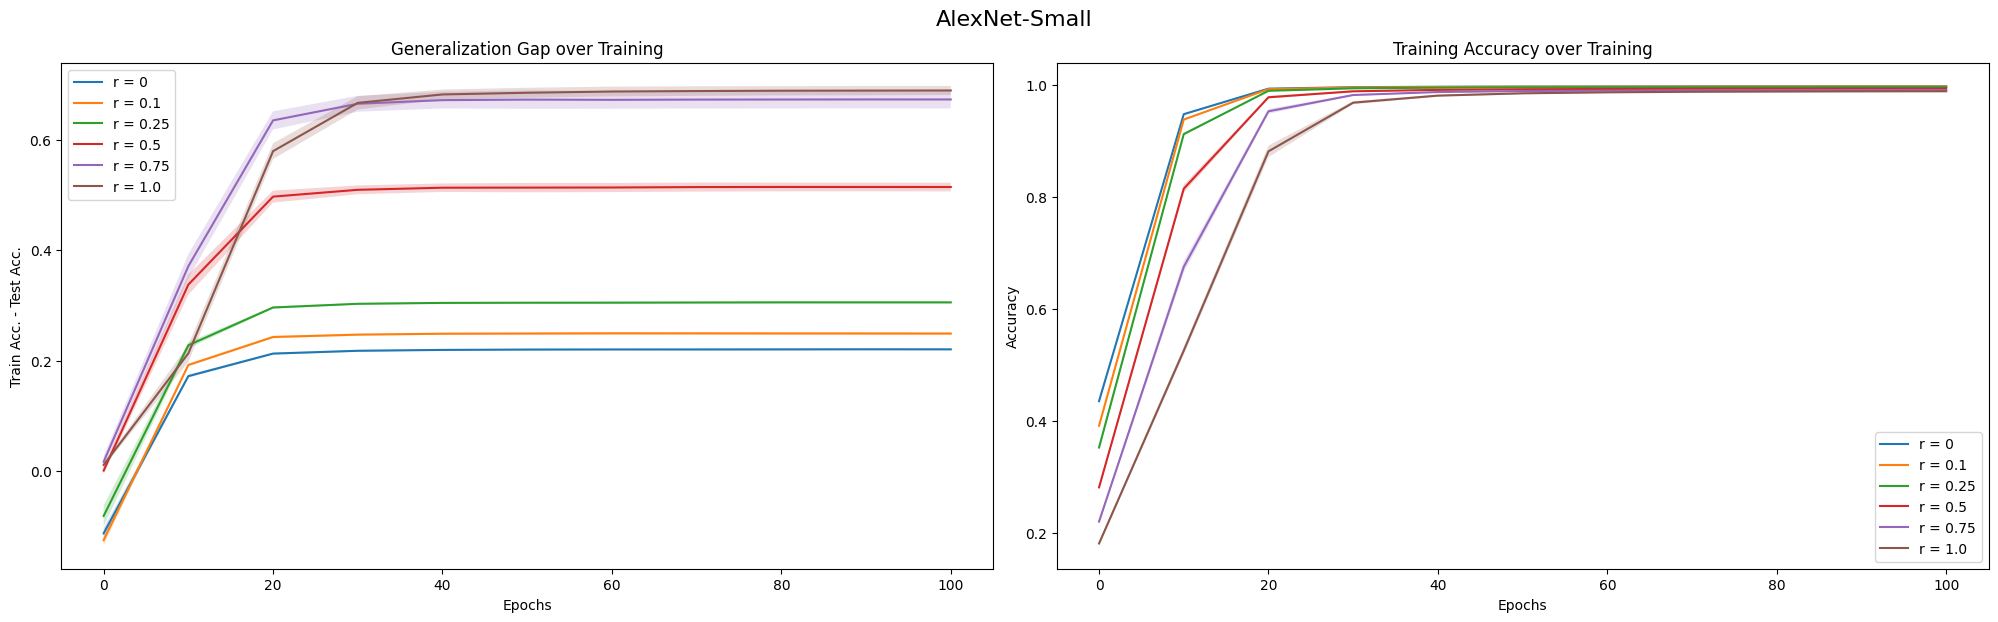

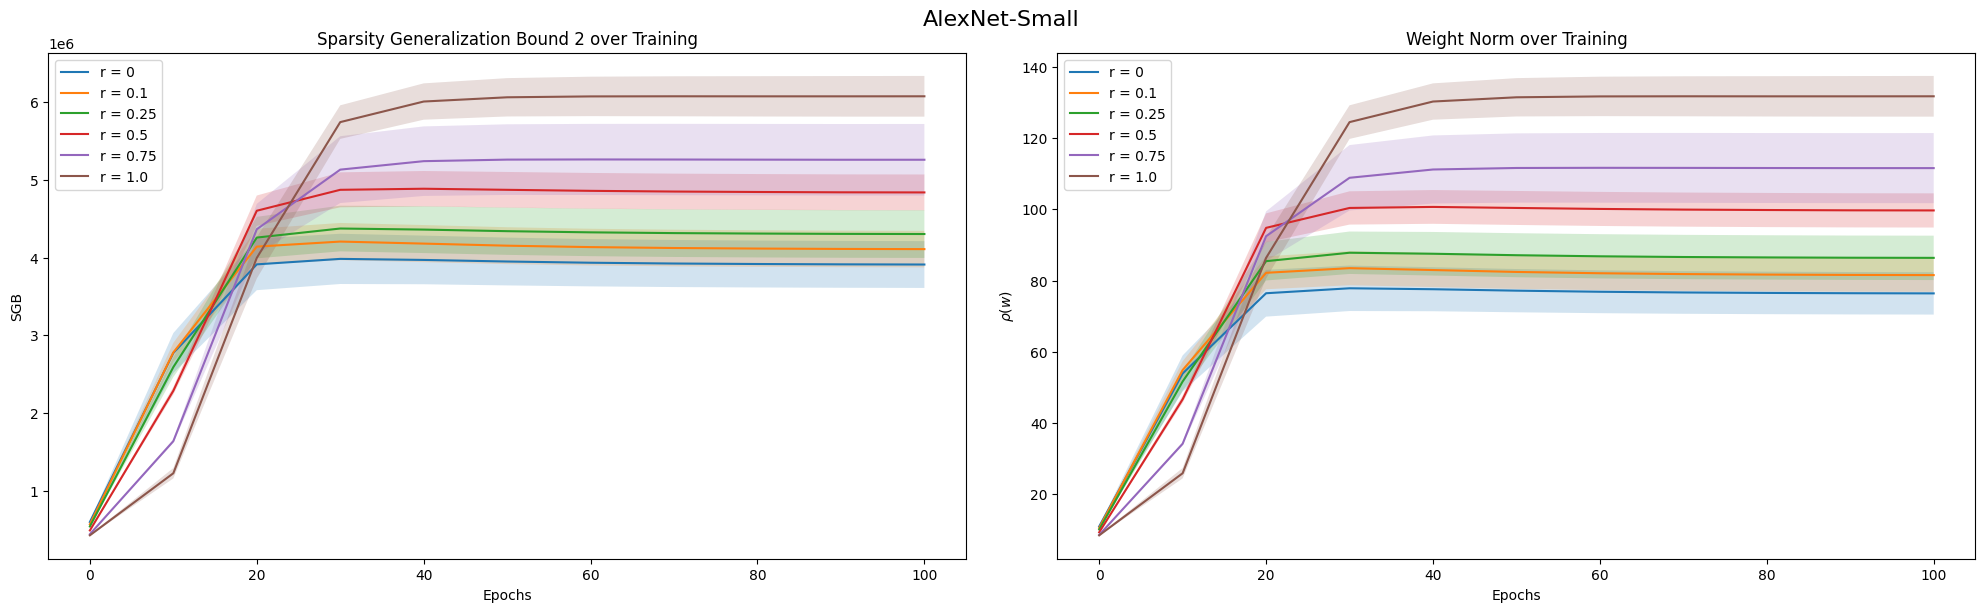

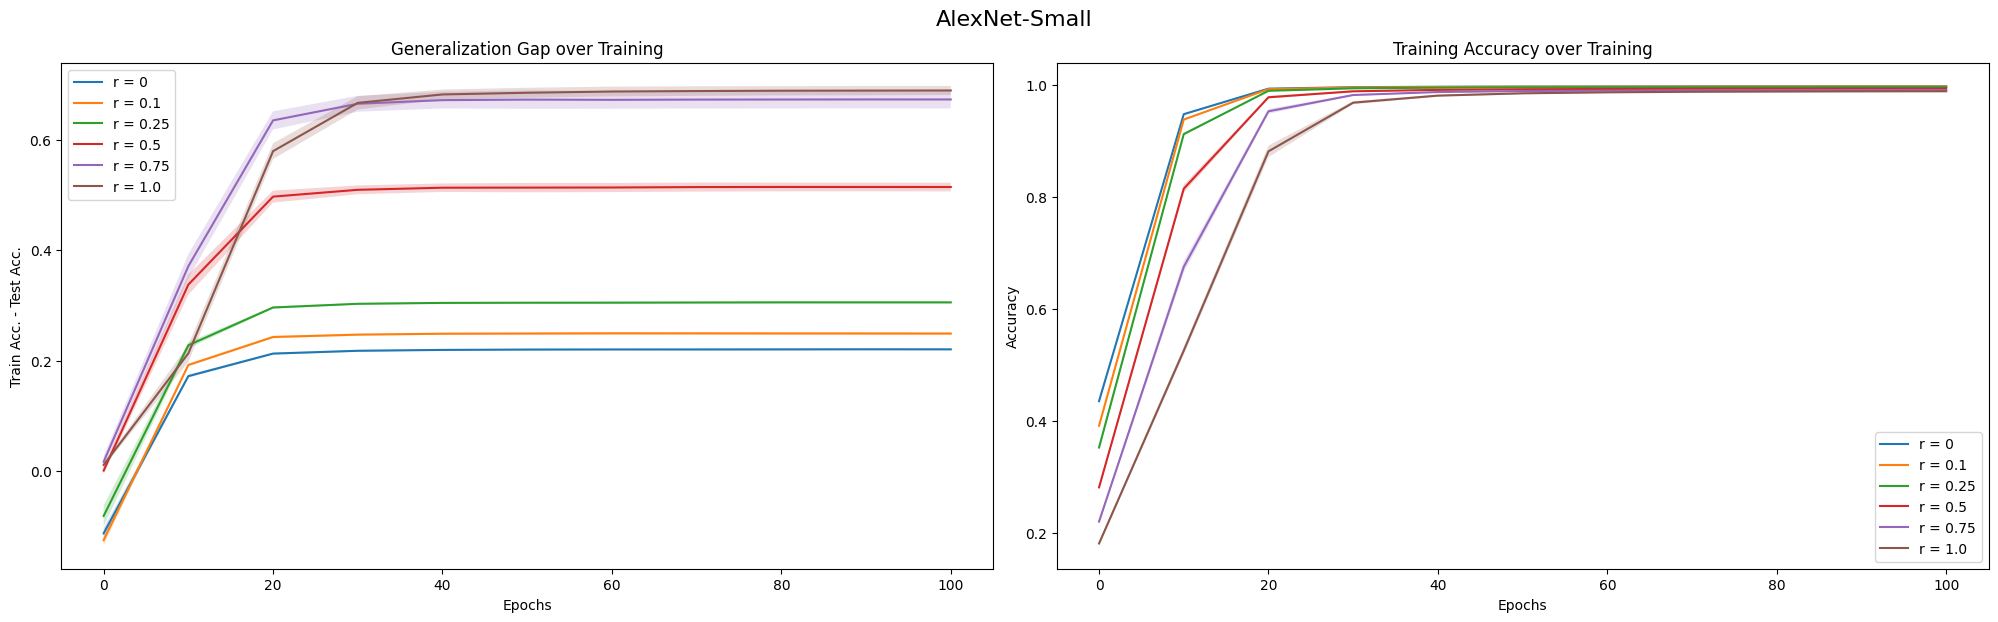

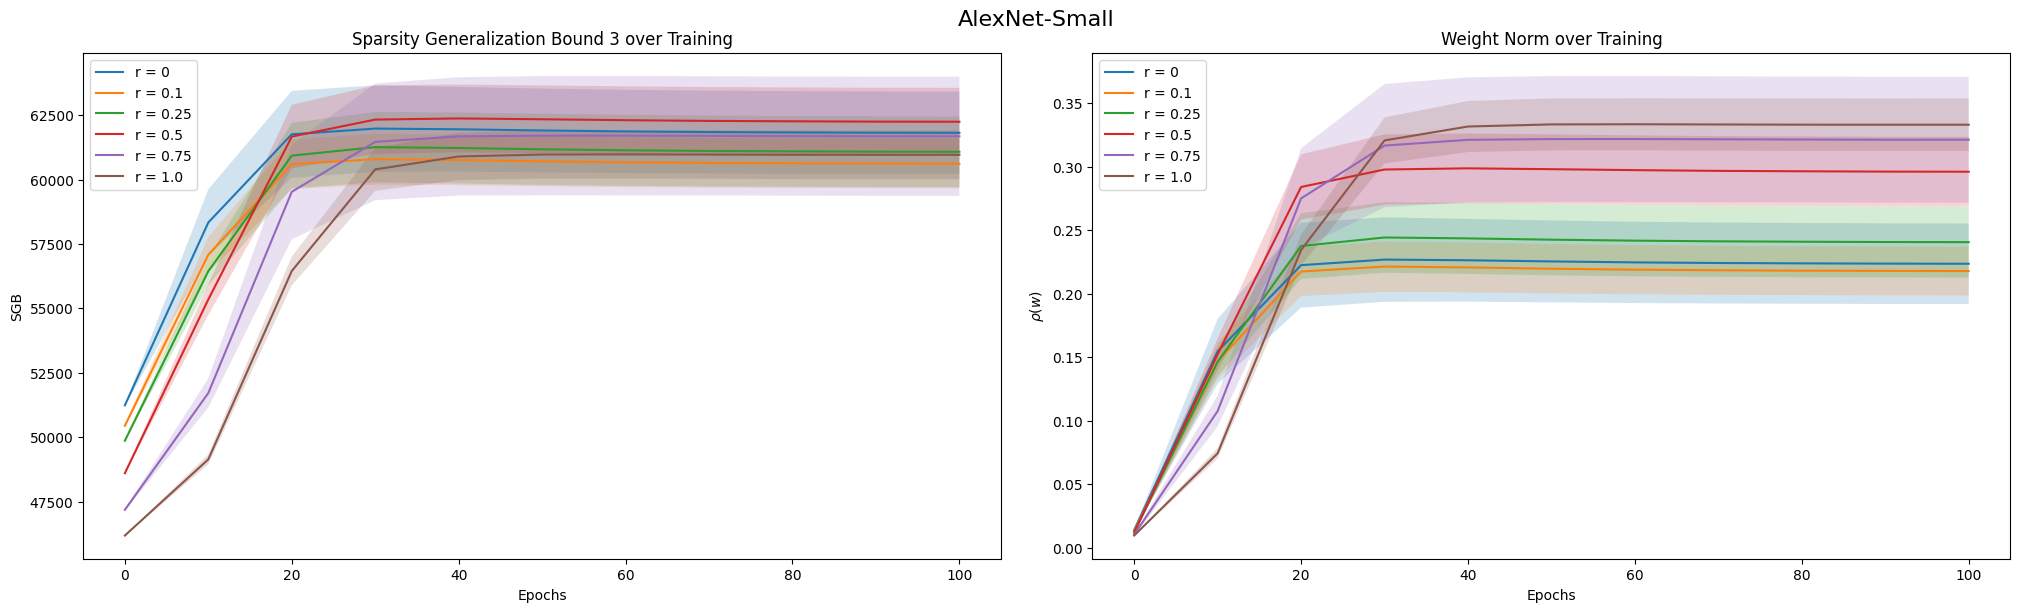

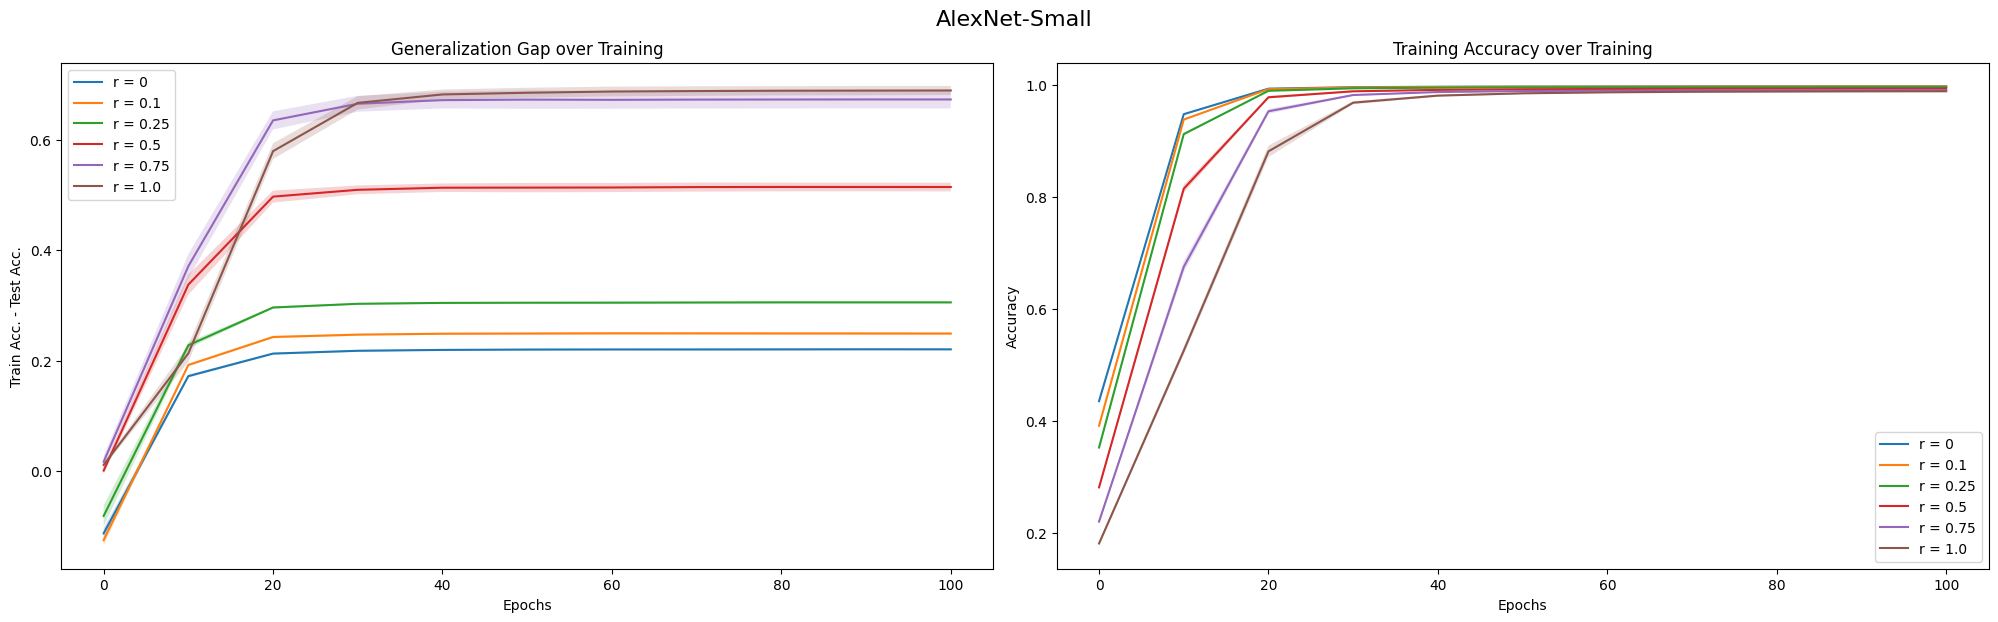

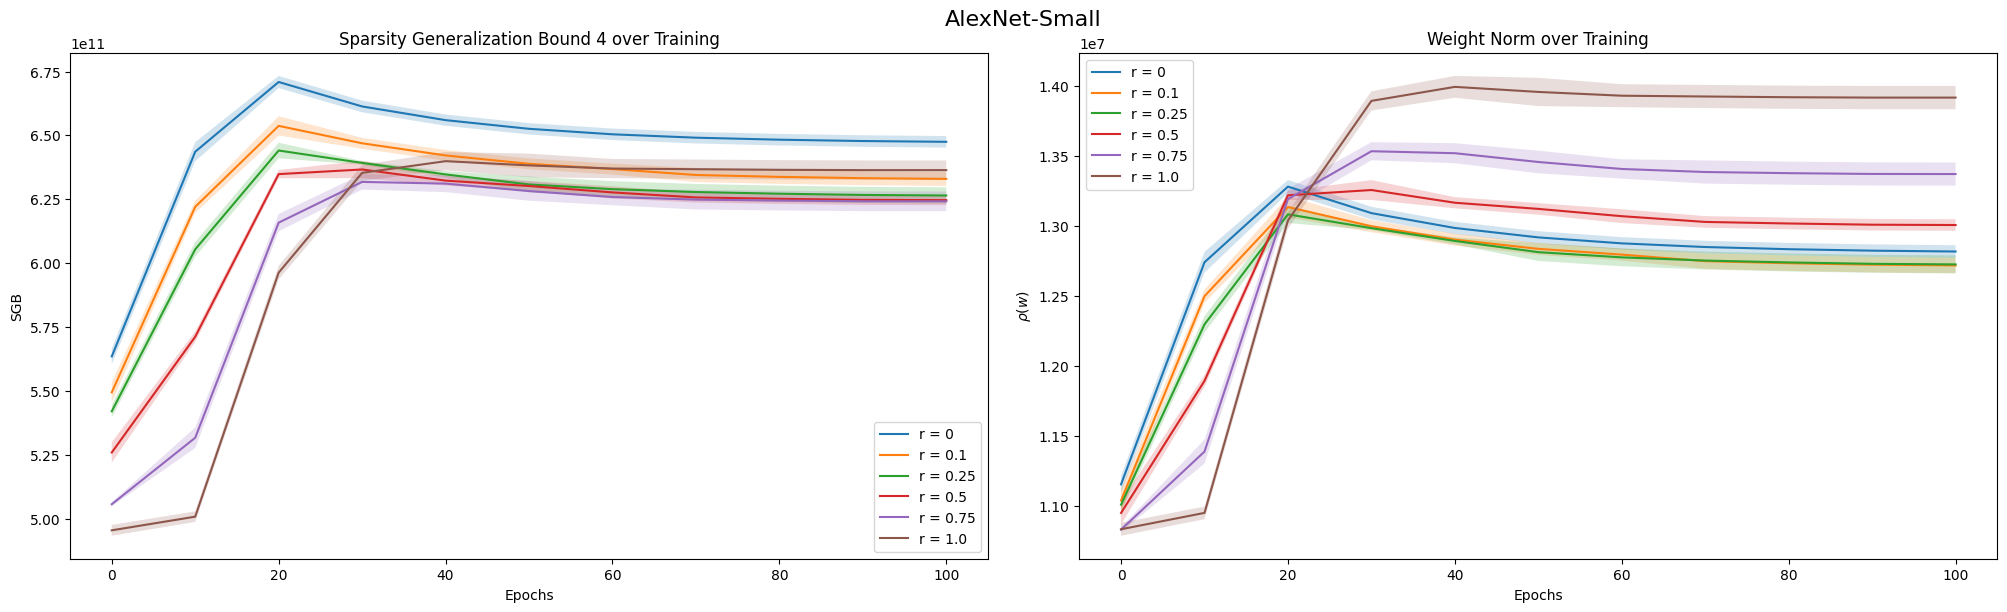

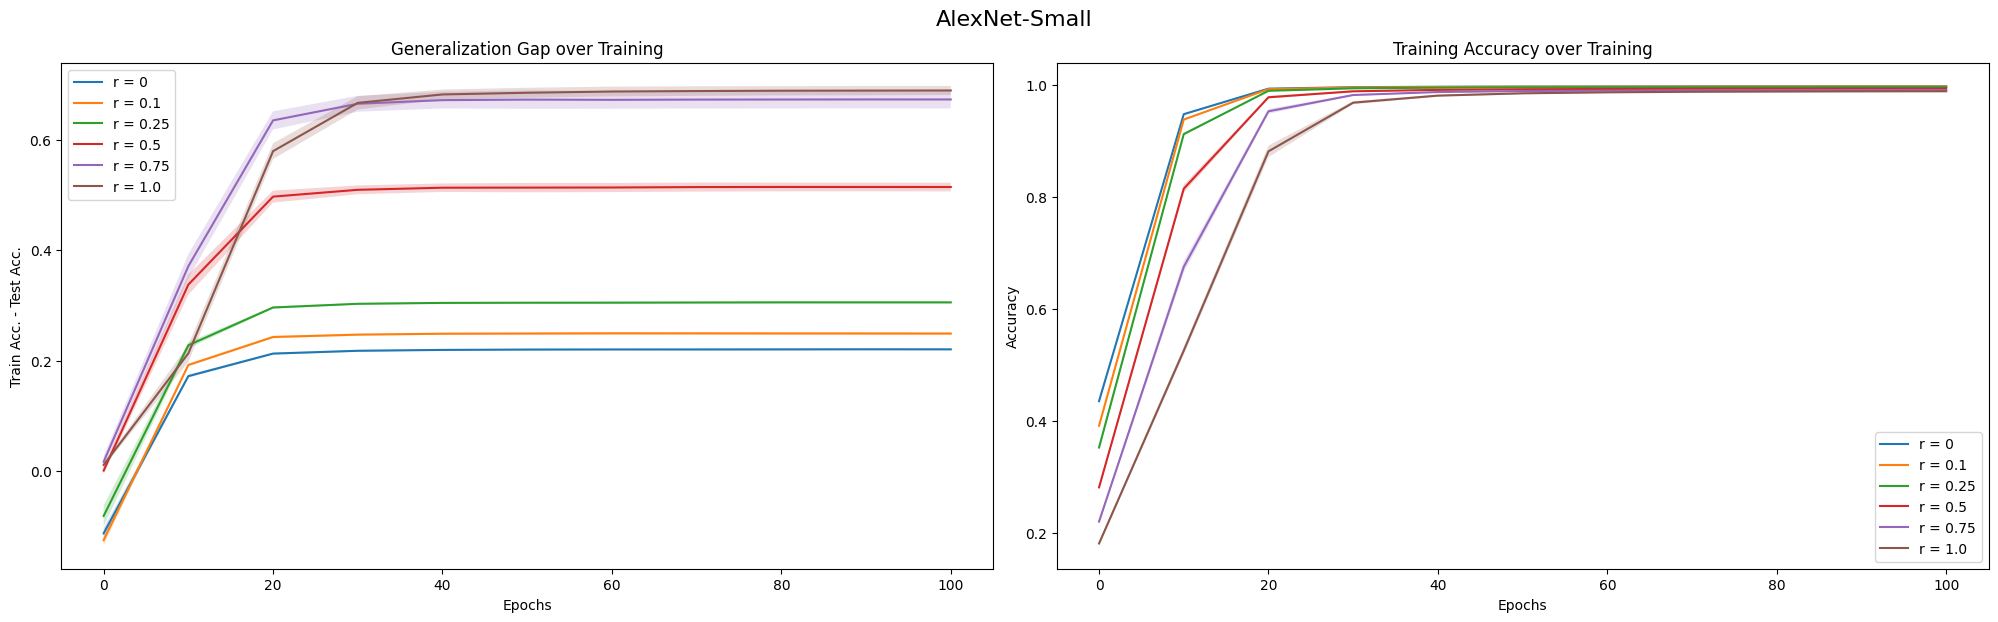

In [71]:
#gaussian
plot()

In [5]:
import pandas as pd

# Calculate the mean of the last train and test accuracies from every model type
mean_train_accuracies = [np.mean(train_accuracy[-1]) for train_accuracy in all_train_accuracies]
mean_test_accuracies = [np.mean(test_accuracy[-1]) for test_accuracy in all_test_accuracies]

# Create a dataframe
df = pd.DataFrame({
    'Model Type': ['AlexNet'] * len(levels),
    'Noise Level': levels,
    'Train Accuracy': mean_train_accuracies,
    'Test Accuracy': mean_test_accuracies
})

print(df)


  Model Type  Noise Level  Train Accuracy  Test Accuracy
0    AlexNet         0.00        0.997936        0.77750
1    AlexNet         0.10        0.997484        0.72276
2    AlexNet         0.25        0.998132        0.60580
3    AlexNet         0.50        0.998240        0.38518
4    AlexNet         0.75        0.998696        0.22644
5    AlexNet         1.00        1.000000        0.10090


In [6]:
model = AlexNet()
total_params = sum(p.numel() for p in model.parameters())
print(total_params)

3042700


/om2/user/jackking/anaconda/envs/modular_transformers/lib/python3.8/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [7]:
import pandas as pd

# Generate LaTeX code for the table
latex_code = df.to_latex(index=False)
print(latex_code)


\begin{tabular}{lrrr}
\toprule
Model Type &  Noise Level &  Train Accuracy &  Test Accuracy \\
\midrule
   AlexNet &         0.00 &        0.997936 &        0.77750 \\
   AlexNet &         0.10 &        0.997484 &        0.72276 \\
   AlexNet &         0.25 &        0.998132 &        0.60580 \\
   AlexNet &         0.50 &        0.998240 &        0.38518 \\
   AlexNet &         0.75 &        0.998696 &        0.22644 \\
   AlexNet &         1.00 &        1.000000 &        0.10090 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_2867277/4167156850.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_code = df.to_latex(index=False)


In [118]:
old_all_train_accuracies = all_train_accuracies.copy()
old_all_test_accuracies = all_test_accuracies.copy()
old_all_bounds = all_bounds.copy()

In [129]:
new_all_train_accuracies = old_all_train_accuracies + all_train_accuracies
new_all_test_accuracies = old_all_test_accuracies + all_test_accuracies
new_all_bounds = {}
for i in range(len(all_bounds)):
    new_all_bounds[i]= all_bounds[i] + old_all_bounds[i]

In [131]:
len(new_all_bounds[0])

12

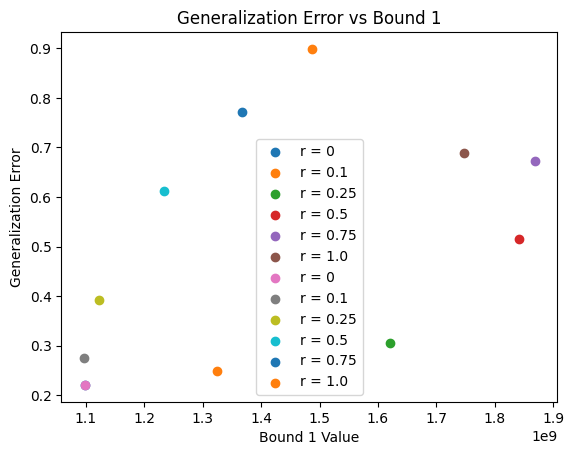

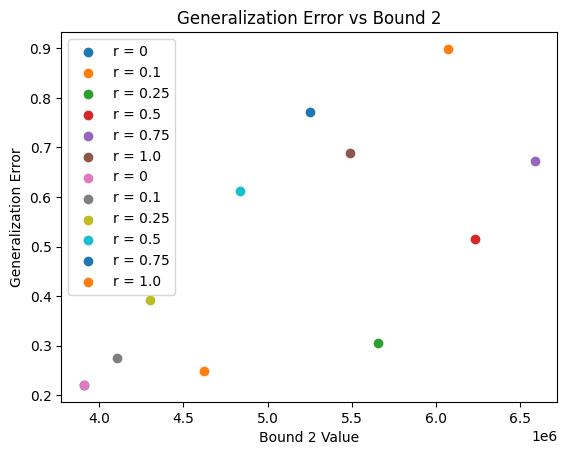

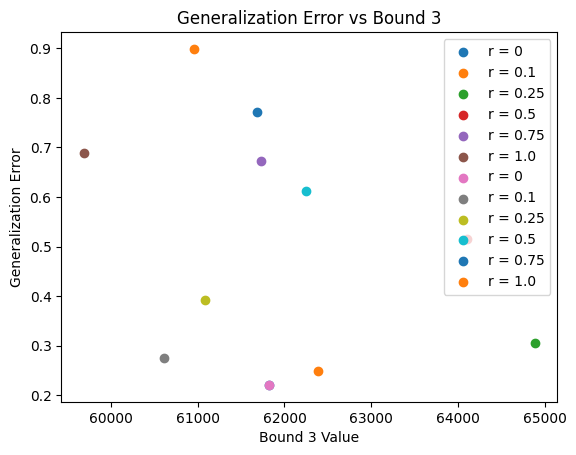

In [134]:
for i in range(3):
    plt.figure()
    for j in range(len(new_all_train_accuracies)):
        generalization_error = new_all_train_accuracies[j] - new_all_test_accuracies[j]
        last_error = np.mean(generalization_error[-1, :])
        last_bound = np.mean(new_all_bounds[i][j][-1, :])
        plt.scatter(last_bound, last_error, label="r = " + str((levels+levels)[j]))

    plt.legend()
    plt.title(f"Generalization Error vs Bound {i+1}")
    plt.xlabel(f"Bound {i+1} Value")
    plt.ylabel("Generalization Error")
    plt.show()